In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import glob
import re
import seaborn as sns
from matplotlib import pyplot as plt
from monty.serialization import loadfn

In [2]:
path = ""

In [3]:
nca_ct = pd.read_csv(path + "NewData/charge_throughputs_BA_NCA.csv")
nca_df = pd.read_csv(path + "NewData/NCABatteries.csv")
nca_ct["battery_index"] = nca_ct["battery"].str[-9:-7].astype(int)

nca_ct_full = nca_df.merge(how = 'inner',right = nca_ct, on = "battery_index")
nca_ct_full = nca_ct_full.add_prefix('X.')
nca_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
nca_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
nca_ct_full["chem"] = "NCA"
nca_ct_full["Temperature"] = nca_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
nca_ct_full["DOD"] = nca_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
nca_ct_full["Discharge_rate"] = nca_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))
nca_ct_full["Charge_rate"] = nca_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))

In [4]:
nmc_ct = pd.read_csv(path + "NewData/charge_throughputs_BA_NMC.csv")
nmc_df = pd.read_csv(path + "NewData/NMCBatteries.csv")
nmc_ct["battery_index"] = nmc_ct["battery"].str[-9:-7].astype(int)

nmc_ct_full = nmc_df.merge(how = 'inner',right = nmc_ct, on = "battery_index")
nmc_ct_full = nmc_ct_full.add_prefix('X.')
nmc_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
nmc_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
nmc_ct_full["chem"] = "NMC"
nmc_ct_full["Temperature"] = nmc_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
nmc_ct_full["DOD"] = nmc_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
nmc_ct_full["Discharge_rate"] = nmc_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))
nmc_ct_full["Charge_rate"] = nmc_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))

In [5]:
lfp_ct = pd.read_csv(path + "NewData/charge_throughputs_BA.csv")
lfp_df = pd.read_csv(path + "NewData/LFPBatteries.csv")
lfp_ct["battery_index"] = lfp_ct["battery"].str[-2:].astype(int)

lfp_ct_full = lfp_df.merge(how = 'inner',right = lfp_ct, on = "battery_index")
lfp_ct_full = lfp_ct_full.add_prefix('X.')
lfp_ct_full.rename(columns={"X.charge_throughput": "charge_throughput"}, inplace=True)
lfp_ct_full.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
lfp_ct_full["chem"] = "LFP"
lfp_ct_full["Temperature"] = lfp_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[1][:2]))
lfp_ct_full["DOD"] = lfp_ct_full["X.battery"].str.split("_").apply(lambda x: int(x[2].split("-")[1]))
lfp_ct_full["Discharge_rate"] = lfp_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[1][:-1]))
lfp_ct_full["Charge_rate"] = lfp_ct_full["X.battery"].str.split("_").apply(lambda x: float(x[3].split("-")[0]))

In [6]:
old_ct = pd.read_csv(path + "OldData/OldDataFullCT.csv")
old_ct.rename(columns={"X.capacity_0.8": "cycle_index"}, inplace=True)
#old_ct
old_ct["chem"] = "OLD"
old_ct["Temperature"] = 30
old_ct["DOD"] = 100
old_ct["Charge_rate"] = 4.8
old_ct["Discharge_rate"] = 4

In [7]:
BA_df = nca_ct_full.append(nmc_ct_full, ignore_index=True).append(lfp_ct_full, ignore_index=True)
BA_df["X.battery"].str.split("_")

0       [NCA, 15C, 0-100, 0.5-1C, a, CH00, struct]
1       [NCA, 15C, 0-100, 0.5-1C, b, CH01, struct]
2       [NCA, 15C, 0-100, 0.5-2C, a, CH02, struct]
3       [NCA, 15C, 0-100, 0.5-2C, b, CH03, struct]
4     [NCA, 25C, 0-100, 0.5-0.5C, a, CH04, struct]
                          ...                     
78              [LFP, 35C, 0-100, 0.5-1C, b, CH25]
79              [LFP, 35C, 0-100, 0.5-1C, c, CH26]
80              [LFP, 35C, 0-100, 0.5-1C, d, CH27]
81              [LFP, 35C, 0-100, 0.5-2C, a, CH28]
82              [LFP, 35C, 0-100, 0.5-2C, b, CH29]
Name: X.battery, Length: 83, dtype: object

In [8]:
BA_df["temp"] = BA_df["X.battery"].str.split("_").apply(lambda x: x[1])
BA_df["Dod"] = BA_df["X.battery"].str.split("_").apply(lambda x: x[2])
BA_df["Discharge_rate"] = BA_df["X.battery"].str.split("_").apply(lambda x: x[3].split("-")[1][:-1])
BA_df["Charge_rate"] = BA_df["X.battery"].str.split("_").apply(lambda x: x[3].split("-")[0])

In [9]:
all_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                      'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                      'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                      'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                      'X.discharge_capacity_cycle_2',
                      'X.max_discharge_capacity_difference',
                      'X.slope_discharge_capacity_cycle_number_2:100',
                      'X.intercept_discharge_capacity_cycle_number_2:100',
                      'X.charge_time_cycles_1:5']

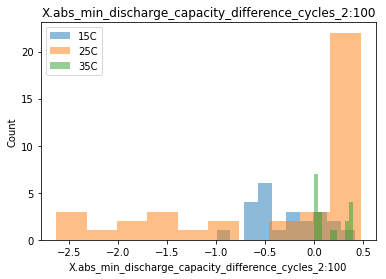

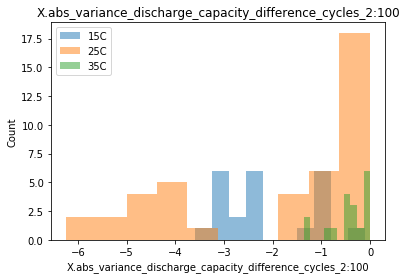

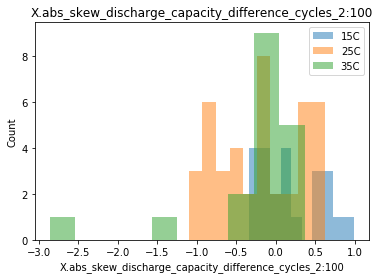

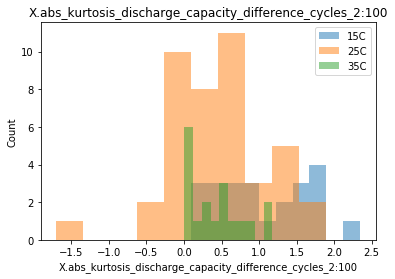

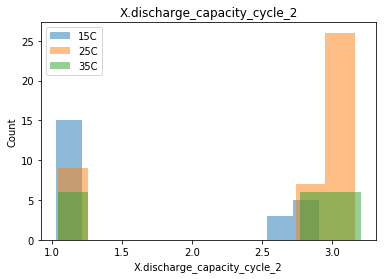

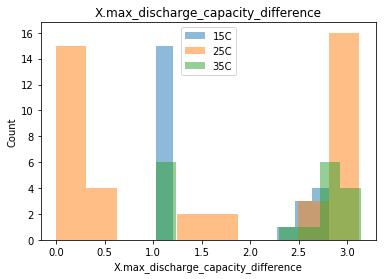

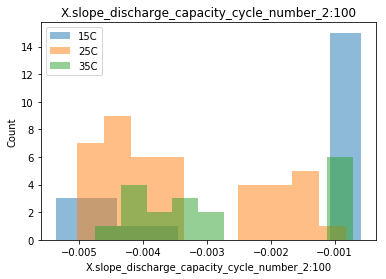

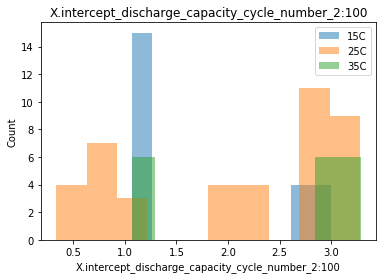

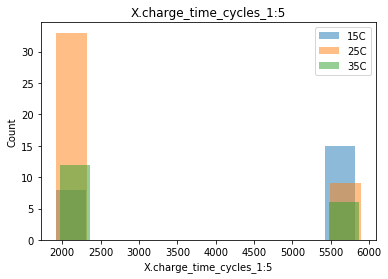

In [10]:
for feat in all_model_features:
    plt.hist(BA_df[BA_df.temp == "15C"][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0), 
             label="15C", alpha = 0.5)
    plt.hist(BA_df[BA_df.temp == "25C"][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0), 
             label="25C", alpha = 0.5)
    plt.hist(BA_df[BA_df.temp == "35C"][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0), 
             label="35C", alpha = 0.5)
    
    plt.title(feat)
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    #BA_df[BA_df.temp == "15C"][feat].plot.hist()

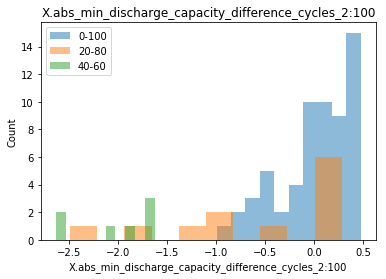

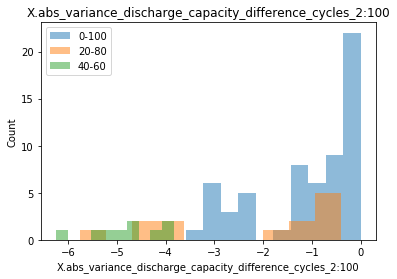

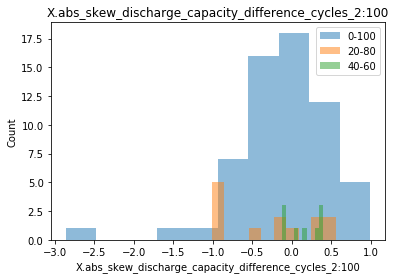

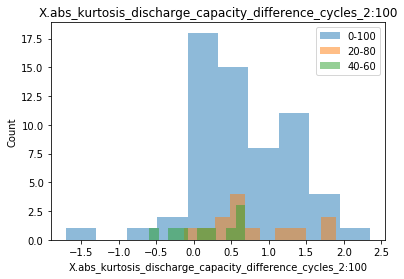

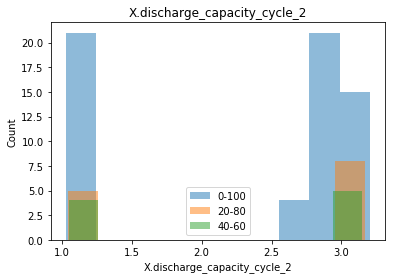

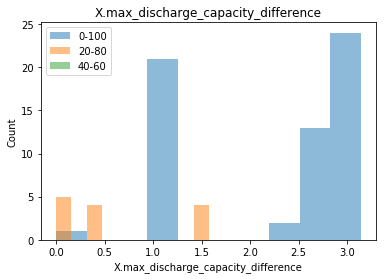

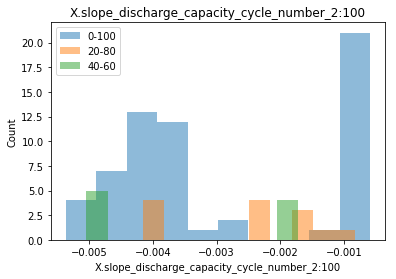

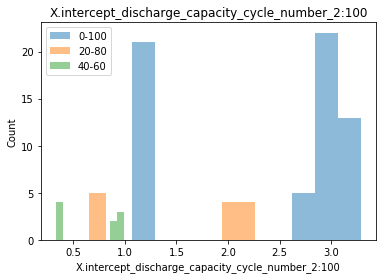

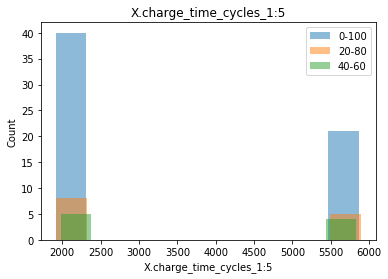

In [11]:
for feat in all_model_features:
    plt.hist(BA_df[BA_df.Dod == "0-100"][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0),
             label="0-100", alpha = 0.5)
    plt.hist(BA_df[BA_df.Dod == "20-80"][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0), 
             label="20-80", alpha = 0.5)
    plt.hist(BA_df[BA_df.Dod == "40-60"][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0), 
             label="40-60", alpha = 0.5)
    
    plt.title(feat)
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    #BA_df[BA_df.temp == "15C"][feat].plot.hist()

In [12]:
# BA_df.Charge_Discharge_rate.unique()

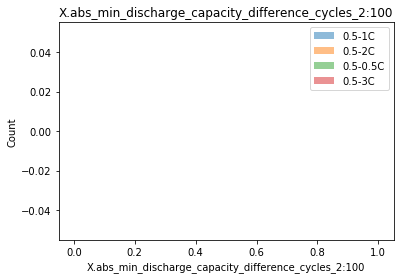

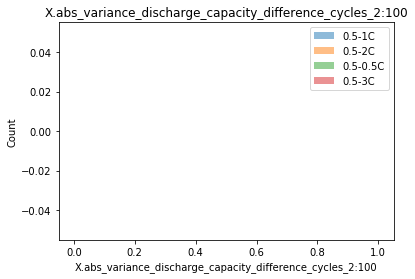

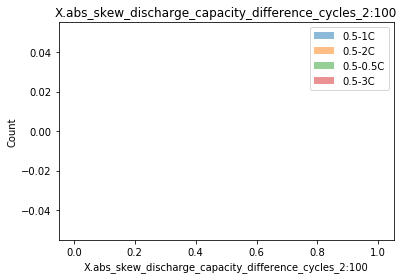

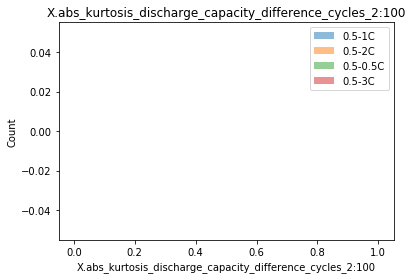

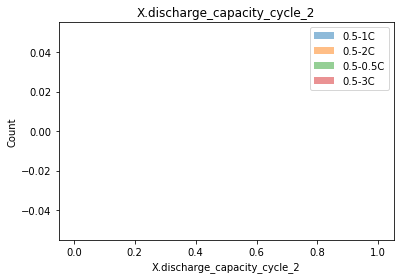

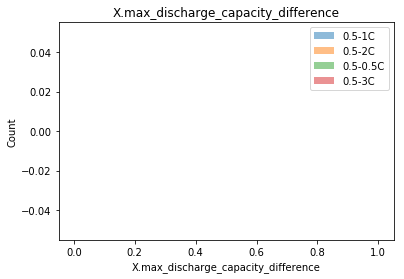

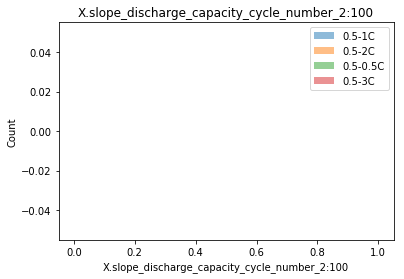

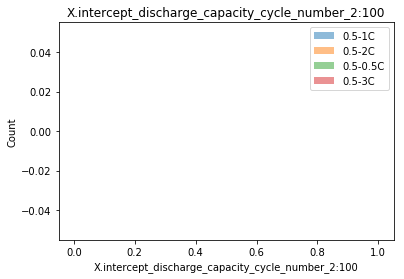

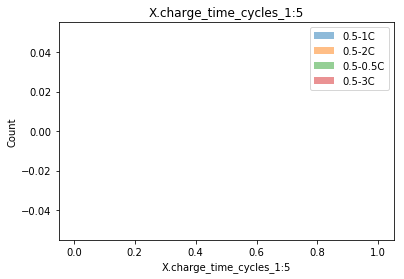

In [13]:
for feat in all_model_features:
    plt.hist(BA_df[BA_df.Discharge_rate == 1][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0),
             label='0.5-1C', alpha = 0.5)
    plt.hist(BA_df[BA_df.Discharge_rate == 2][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0), 
             label='0.5-2C', alpha = 0.5)
    plt.hist(BA_df[BA_df.Discharge_rate == 0.5][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0), 
             label='0.5-0.5C', alpha = 0.5)
    plt.hist(BA_df[BA_df.Discharge_rate == 3][feat].replace([np.inf, -np.inf], np.nan).dropna(axis=0), 
             label='0.5-3C', alpha = 0.5)
    
    plt.title(feat)
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.legend()
    plt.show()

## Check the values versus CT

In [38]:
variance_model_features = 'X.abs_variance_discharge_capacity_difference_cycles_2:100'
discharge_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                            'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                            'X.abs_skew_discharge_capacity_difference_cycles_2:100',
                            'X.abs_kurtosis_discharge_capacity_difference_cycles_2:100',
                            'X.discharge_capacity_cycle_2',
                            'X.max_discharge_capacity_difference']
full_model_features = ['X.abs_min_discharge_capacity_difference_cycles_2:100',
                       'X.abs_variance_discharge_capacity_difference_cycles_2:100',
                       'X.slope_discharge_capacity_cycle_number_2:100',
                       'X.intercept_discharge_capacity_cycle_number_2:100',
                       'X.discharge_capacity_cycle_2',
                       'X.charge_time_cycles_1:5', 
                       'Temperature',
                       'DOD',
                       'Discharge_rate',
                       'Charge_rate']
all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features)) + ["chem", "charge_throughput"]

In [39]:
full_df = nca_ct_full.append(nmc_ct_full, ignore_index=True).append(lfp_ct_full, ignore_index=True).append(old_ct, ignore_index=True)
full_df = full_df[all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0)

In [40]:
full_df

,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.slope_discharge_capacity_cycle_number_2:100,X.intercept_discharge_capacity_cycle_number_2:100,X.discharge_capacity_cycle_2,X.charge_time_cycles_1:5,Temperature,DOD,Discharge_rate,Charge_rate,X.max_discharge_capacity_difference,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,chem,charge_throughput
0,-0.556555,-2.537839,-0.004213,2.992012,2.911000,1920.000000,15,100,1.0,0.5,2.817000,0.091227,-0.198558,NCA,1261.478000
1,-0.705399,-2.727858,-0.003508,2.952953,2.895000,1920.000000,15,100,1.0,0.5,2.795000,0.089352,-0.252584,NCA,2205.619000
2,0.148826,-1.115799,-0.004496,2.962792,2.870000,1971.199951,15,100,2.0,0.5,2.514000,0.852673,0.321565,NCA,1841.362000
3,0.414443,-0.100452,-0.004436,2.960748,2.901000,1996.800049,15,100,2.0,0.5,2.435000,0.183003,-0.334105,NCA,1702.899000
5,0.472261,-0.042873,-0.005005,3.278150,3.158000,1971.199951,25,100,0.5,0.5,3.119000,0.092382,-0.129626,NCA,1434.111000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,-1.393213,-3.505890,0.000012,1.076001,1.068216,588.799988,30,100,4.0,4.8,0.887755,0.274962,-1.799734,OLD,559.666321
218,-1.400177,-3.587016,-0.000001,1.074493,1.066163,640.000000,30,100,4.0,4.8,0.886750,0.243095,-1.262057,OLD,530.511353
219,-1.250446,-3.192149,0.000039,1.083859,1.074378,614.400024,30,100,4.0,4.8,0.888332,0.286883,-1.060782,OLD,503.733368
220,-1.295779,-3.296541,0.000026,1.083195,1.075889,588.799988,30,100,4.0,4.8,0.892131,0.283520,-1.022332,OLD,571.515808


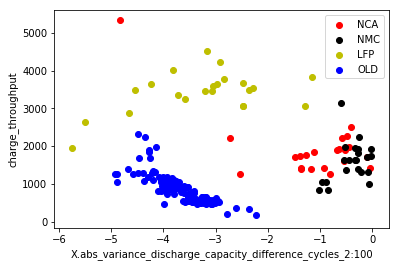

In [41]:
plt.scatter(full_df[full_df.chem == "NCA"][variance_model_features], 
            full_df[full_df.chem == "NCA"]["charge_throughput"], color='r')
plt.scatter(full_df[full_df.chem == "NMC"][variance_model_features], 
            full_df[full_df.chem == "NMC"]["charge_throughput"], color='k')
plt.scatter(full_df[full_df.chem == "LFP"][variance_model_features], 
            full_df[full_df.chem == "LFP"]["charge_throughput"], color='y')
plt.scatter(full_df[full_df.chem == "OLD"][variance_model_features], 
            full_df[full_df.chem == "OLD"]["charge_throughput"], color='b')
plt.xlabel(variance_model_features)
labels = ["NCA", "NMC", "LFP", "OLD"]
plt.ylabel("charge_throughput")
plt.legend(labels)

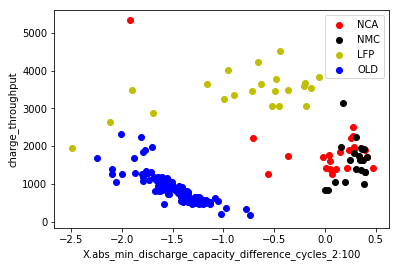

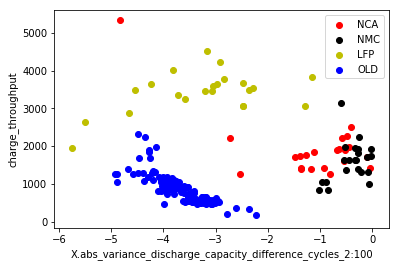

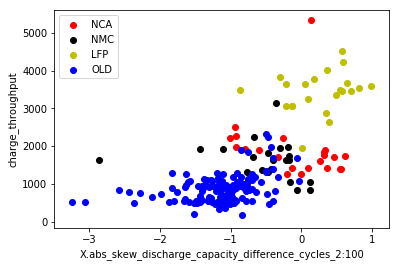

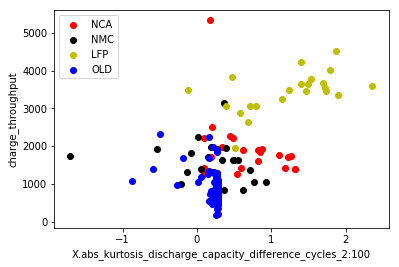

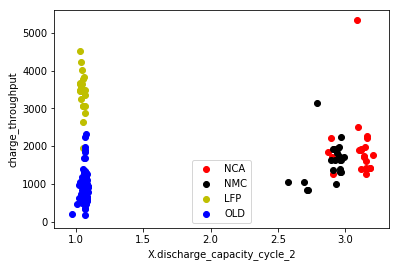

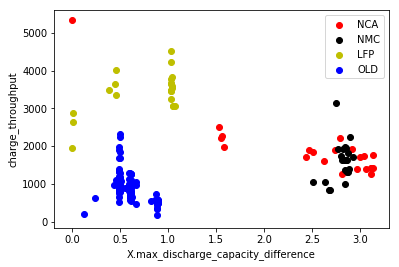

In [42]:
for feat in discharge_model_features:
    plt.scatter(full_df[full_df.chem == "NCA"][feat], 
                full_df[full_df.chem == "NCA"]["charge_throughput"], color='r')
    plt.scatter(full_df[full_df.chem == "NMC"][feat], 
                full_df[full_df.chem == "NMC"]["charge_throughput"], color='k')
    plt.scatter(full_df[full_df.chem == "LFP"][feat], 
                full_df[full_df.chem == "LFP"]["charge_throughput"], color='y')
    plt.scatter(full_df[full_df.chem == "OLD"][feat], 
                full_df[full_df.chem == "OLD"]["charge_throughput"], color='b')
    plt.xlabel(feat)
    labels = ["NCA", "NMC", "LFP", "OLD"]
    plt.ylabel("charge_throughput")
    plt.legend(labels)
    plt.show()
    plt.close()

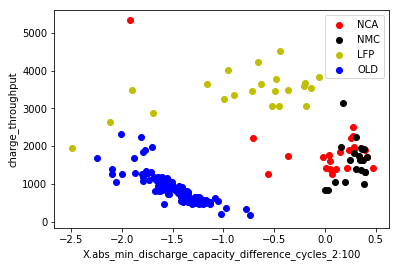

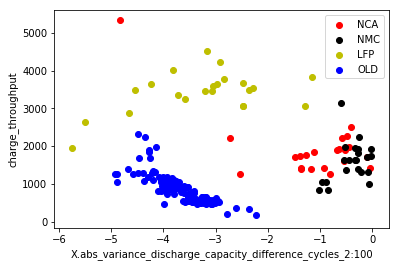

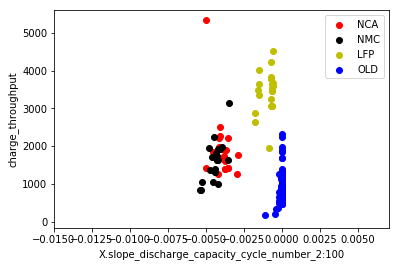

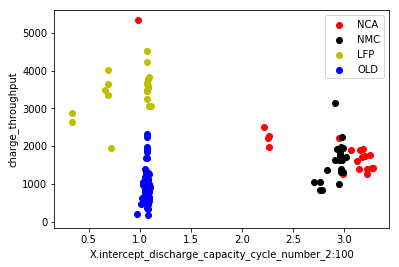

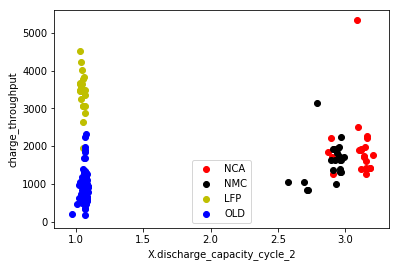

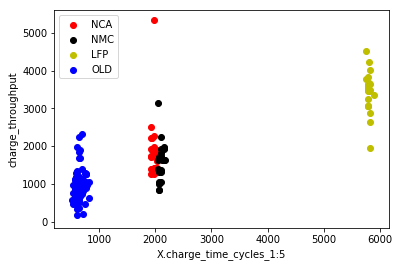

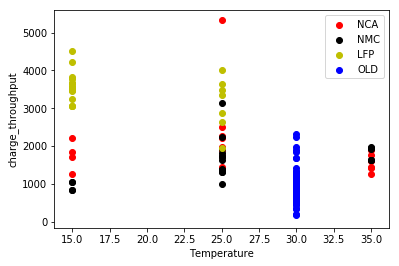

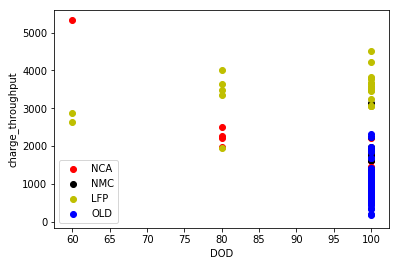

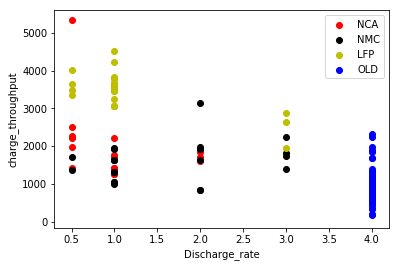

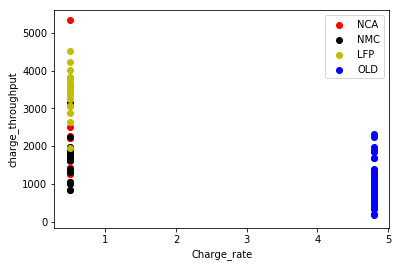

In [43]:
for feat in full_model_features:
    plt.scatter(full_df[full_df.chem == "NCA"][feat], 
                full_df[full_df.chem == "NCA"]["charge_throughput"], color='r')
    plt.scatter(full_df[full_df.chem == "NMC"][feat], 
                full_df[full_df.chem == "NMC"]["charge_throughput"], color='k')
    plt.scatter(full_df[full_df.chem == "LFP"][feat], 
                full_df[full_df.chem == "LFP"]["charge_throughput"], color='y')
    plt.scatter(full_df[full_df.chem == "OLD"][feat], 
                full_df[full_df.chem == "OLD"]["charge_throughput"], color='b')
    plt.xlabel(feat)
    labels = ["NCA", "NMC", "LFP", "OLD"]
    plt.ylabel("charge_throughput")
    plt.legend(labels)
    plt.show()
    plt.close()

## Check with scalers

In [44]:
from sklearn.preprocessing import RobustScaler, StandardScaler
standardized = True
all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))

In [45]:
if standardized:
    

    def standardize(X_train, var=False):
        scaler = RobustScaler()
        if var: 
            scaled_X_train = scaler.fit_transform(np.array(X_train).reshape(-1,1))
            X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=[X_train.name])
#             scaled_X_test = scaler.transform(np.array(X_test).reshape(-1,1))
#             X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=[X_test.name])
        else:
            scaled_X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
#             scaled_X_test = scaler.transform(X_test)
#             X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)
        return X_train

In [46]:
nca_ct_full_sc = standardize(nca_ct_full[all_model_features])
nca_ct_full_sc["chem"] = "NCA"
nca_ct_full_sc["charge_throughput"] = nca_ct_full["charge_throughput"]

In [47]:
nmc_ct_full_sc = standardize(nmc_ct_full[all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0))
nmc_ct_full_sc["chem"] = "NMC"
nmc_ct_full_sc["charge_throughput"] = nmc_ct_full.loc[nmc_ct_full_sc.index, "charge_throughput"]

In [48]:
lfp_ct_full_sc = standardize(lfp_ct_full[all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0))
lfp_ct_full_sc["chem"] = "LFP"
lfp_ct_full_sc["charge_throughput"] = lfp_ct_full.loc[lfp_ct_full_sc.index, "charge_throughput"]

In [49]:
old_ct_full_sc = standardize(old_ct[all_model_features])
old_ct_full_sc["chem"] = "OLD"
old_ct_full_sc["charge_throughput"] = old_ct.loc[old_ct.index, "charge_throughput"]

In [50]:
full_sc_df = nca_ct_full_sc.append(nmc_ct_full_sc, ignore_index=True).append(lfp_ct_full_sc, ignore_index=True).append(old_ct_full_sc, ignore_index=True)
full_sc_df = full_sc_df

In [51]:
full_sc_df

,X.abs_min_discharge_capacity_difference_cycles_2:100,X.abs_variance_discharge_capacity_difference_cycles_2:100,X.slope_discharge_capacity_cycle_number_2:100,X.intercept_discharge_capacity_cycle_number_2:100,X.discharge_capacity_cycle_2,X.charge_time_cycles_1:5,Temperature,DOD,Discharge_rate,Charge_rate,X.max_discharge_capacity_difference,X.abs_kurtosis_discharge_capacity_difference_cycles_2:100,X.abs_skew_discharge_capacity_difference_cycles_2:100,chem,charge_throughput
0,-2.463190,-1.955340,-0.787685,-0.250651,-4.255708,-0.761904,-4.0,0.0,0.000000,0.0,0.032948,-0.635778,-0.339373,NCA,1261.478000
1,-2.999224,-2.178036,0.471380,-0.341989,-4.547945,-0.761904,-4.0,0.0,0.000000,0.0,0.018003,-0.638281,-0.413821,NCA,2205.619000
2,0.077106,-0.288762,-1.294088,-0.318981,-5.004566,0.000000,-4.0,0.0,1.333333,0.0,-0.172894,0.380909,0.377348,NCA,1841.362000
3,1.033676,0.901187,-1.187795,-0.323760,-4.438356,0.380954,-4.0,0.0,1.333333,0.0,-0.226562,-0.513238,-0.526156,NCA,1702.899000
4,0.371024,0.789676,4.230209,-0.271499,0.310502,0.190477,0.0,0.0,-0.666667,0.0,-1.880774,-0.622010,0.193688,NCA,1354.915000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.181602,0.184460,0.621100,0.092200,-0.040938,-0.500001,0.0,0.0,0.000000,0.0,0.726158,0.145675,-1.344722,OLD,559.666321
203,0.158504,0.057815,0.048814,-0.027266,-0.240514,0.499999,0.0,0.0,0.000000,0.0,0.723551,-1.147777,-0.339727,OLD,530.511353
204,0.655154,0.674233,1.737485,0.715012,0.558063,0.000000,0.0,0.0,0.000000,0.0,0.727652,0.629496,0.036486,OLD,503.733368
205,0.504786,0.511269,1.193792,0.662436,0.704938,-0.500001,0.0,0.0,0.000000,0.0,0.737502,0.493022,0.108355,OLD,571.515808


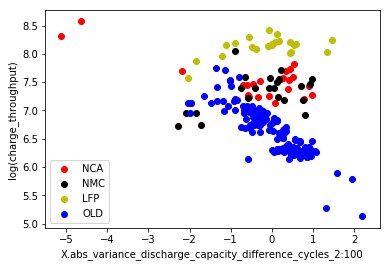

In [52]:
plt.scatter(full_sc_df[full_sc_df.chem == "NCA"][variance_model_features], 
            np.log(full_sc_df[full_sc_df.chem == "NCA"]["charge_throughput"]), color='r')
plt.scatter(full_sc_df[full_sc_df.chem == "NMC"][variance_model_features], 
            np.log(full_sc_df[full_sc_df.chem == "NMC"]["charge_throughput"]), color='k')
plt.scatter(full_sc_df[full_sc_df.chem == "LFP"][variance_model_features], 
            np.log(full_sc_df[full_sc_df.chem == "LFP"]["charge_throughput"]), color='y')
plt.scatter(full_sc_df[full_sc_df.chem == "OLD"][variance_model_features], 
            np.log(full_sc_df[full_sc_df.chem == "OLD"]["charge_throughput"]), color='b')
plt.xlabel(variance_model_features)
labels = ["NCA", "NMC", "LFP", "OLD"]
plt.ylabel("log(charge_throughput)")
plt.legend(labels)

Discharge_model


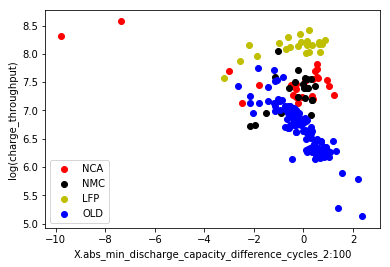

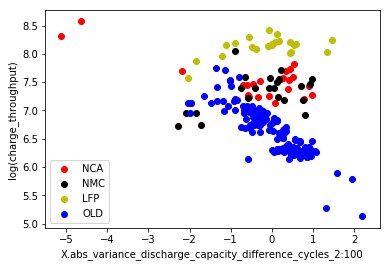

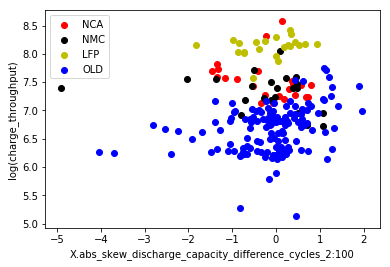

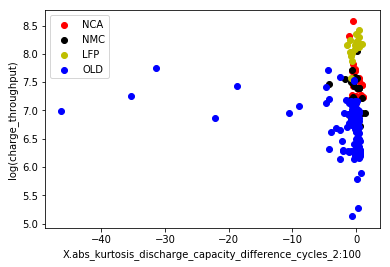

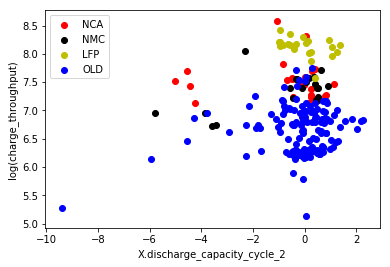

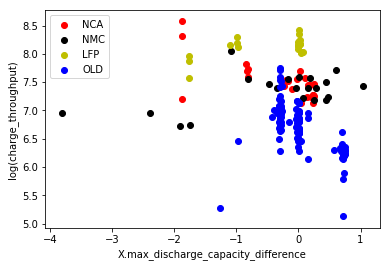

In [53]:
print("Discharge_model")
for feat in discharge_model_features:
    plt.scatter(full_sc_df[full_sc_df.chem == "NCA"][feat], 
                np.log(full_sc_df[full_sc_df.chem == "NCA"]["charge_throughput"]), color='r')
    plt.scatter(full_sc_df[full_sc_df.chem == "NMC"][feat], 
                np.log(full_sc_df[full_sc_df.chem == "NMC"]["charge_throughput"]), color='k')
    plt.scatter(full_sc_df[full_sc_df.chem == "LFP"][feat], 
                np.log(full_sc_df[full_sc_df.chem == "LFP"]["charge_throughput"]), color='y')
    plt.scatter(full_sc_df[full_sc_df.chem == "OLD"][feat], 
                np.log(full_sc_df[full_sc_df.chem == "OLD"]["charge_throughput"]), color='b')
    plt.xlabel(feat)
    labels = ["NCA", "NMC", "LFP", "OLD"]
    plt.ylabel("log(charge_throughput)")
    plt.legend(labels)
    plt.show()
    plt.close()

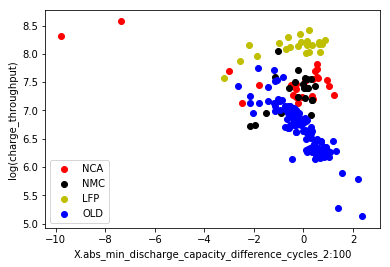

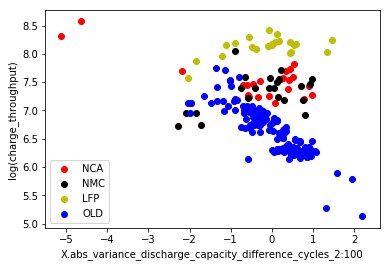

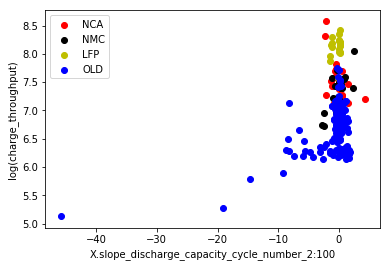

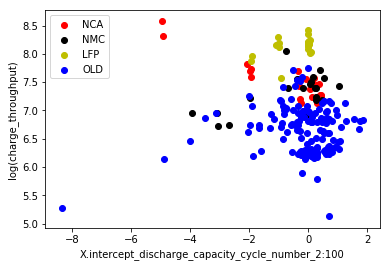

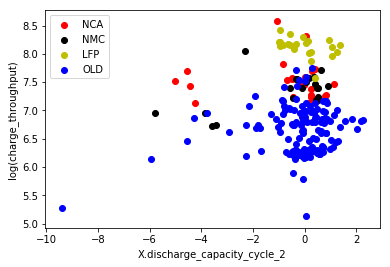

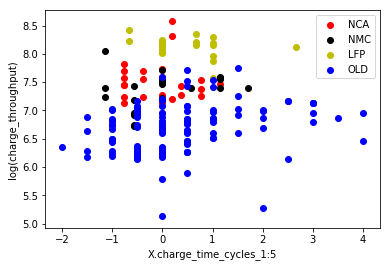

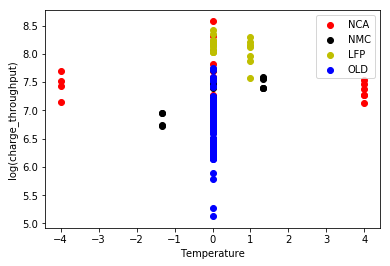

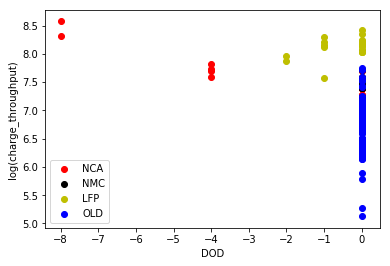

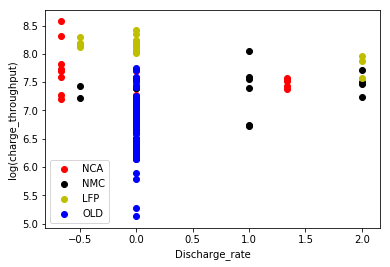

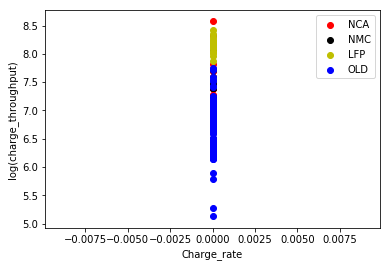

In [54]:
for feat in full_model_features:
    plt.scatter(full_sc_df[full_sc_df.chem == "NCA"][feat], 
                np.log(full_sc_df[full_sc_df.chem == "NCA"]["charge_throughput"]), color='r')
    plt.scatter(full_sc_df[full_sc_df.chem == "NMC"][feat], 
                np.log(full_sc_df[full_sc_df.chem == "NMC"]["charge_throughput"]), color='k')
    plt.scatter(full_sc_df[full_sc_df.chem == "LFP"][feat], 
                np.log(full_sc_df[full_sc_df.chem == "LFP"]["charge_throughput"]), color='y')
    plt.scatter(full_sc_df[full_sc_df.chem == "OLD"][feat], 
                np.log(full_sc_df[full_sc_df.chem == "OLD"]["charge_throughput"]), color='b')
    plt.xlabel(feat)
    labels = ["NCA", "NMC", "LFP", "OLD"]
    plt.ylabel("log(charge_throughput)")
    plt.legend(labels)
    plt.show()
    plt.close()

## Check with scaling together

In [55]:
from sklearn.preprocessing import RobustScaler, StandardScaler
standardized = True
all_model_features = full_model_features + list(set(discharge_model_features)-set(full_model_features))

In [56]:
if standardized:
    

    def standardize(X_train, var=False):
        scaler = RobustScaler()
        if var: 
            scaled_X_train = scaler.fit_transform(np.array(X_train).reshape(-1,1))
            X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=[X_train.name])
#             scaled_X_test = scaler.transform(np.array(X_test).reshape(-1,1))
#             X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=[X_test.name])
        else:
            scaled_X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
#             scaled_X_test = scaler.transform(X_test)
#             X_test = pd.DataFrame(scaled_X_test, index=X_test.index, columns=X_test.columns)
        return X_train

In [57]:
full_sc_df = nca_ct_full_sc.append(nmc_ct_full_sc, ignore_index=True).append(lfp_ct_full_sc, ignore_index=True).append(old_ct_full_sc, ignore_index=True)
full_sc_df = full_sc_df

In [58]:
full_df_sc = standardize(full_df[all_model_features].replace([np.inf, -np.inf, 0.0], np.nan).dropna(axis=0))
full_df_sc["chem"] = full_df.loc[full_df_sc.index, "chem"]
full_df_sc["charge_throughput"] = full_df.loc[full_df_sc.index, "charge_throughput"]

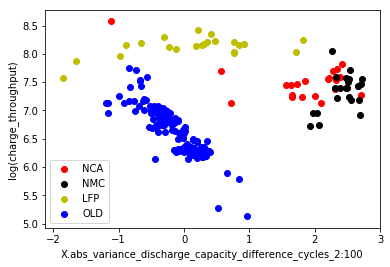

In [59]:
plt.scatter(full_df_sc[full_df_sc.chem == "NCA"][variance_model_features], 
            np.log(full_df_sc[full_df_sc.chem == "NCA"]["charge_throughput"]), color='r')
plt.scatter(full_df_sc[full_df_sc.chem == "NMC"][variance_model_features], 
            np.log(full_df_sc[full_df_sc.chem == "NMC"]["charge_throughput"]), color='k')
plt.scatter(full_df_sc[full_df_sc.chem == "LFP"][variance_model_features], 
            np.log(full_df_sc[full_df_sc.chem == "LFP"]["charge_throughput"]), color='y')
plt.scatter(full_df_sc[full_df_sc.chem == "OLD"][variance_model_features], 
            np.log(full_df_sc[full_df_sc.chem == "OLD"]["charge_throughput"]), color='b')
plt.xlabel(variance_model_features)
labels = ["NCA", "NMC", "LFP", "OLD"]
plt.ylabel("log(charge_throughput)")
plt.legend(labels)

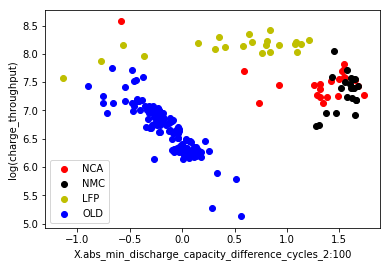

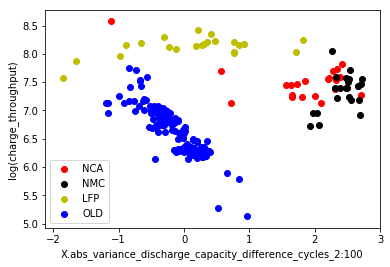

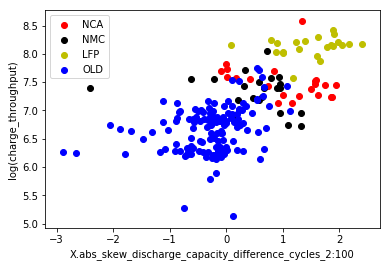

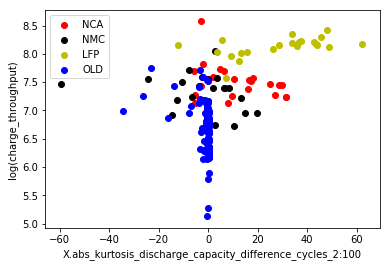

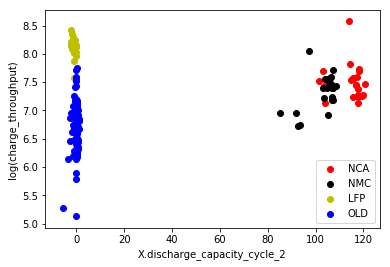

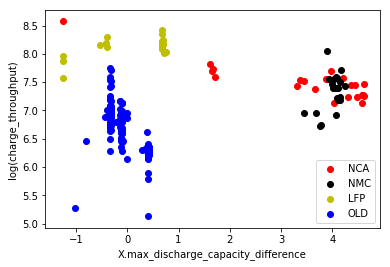

In [60]:
for feat in discharge_model_features:
    plt.scatter(full_df_sc[full_df_sc.chem == "NCA"][feat], 
                np.log(full_df_sc[full_df_sc.chem == "NCA"]["charge_throughput"]), color='r')
    plt.scatter(full_df_sc[full_df_sc.chem == "NMC"][feat], 
                np.log(full_df_sc[full_df_sc.chem == "NMC"]["charge_throughput"]), color='k')
    plt.scatter(full_df_sc[full_df_sc.chem == "LFP"][feat], 
                np.log(full_df_sc[full_df_sc.chem == "LFP"]["charge_throughput"]), color='y')
    plt.scatter(full_df_sc[full_df_sc.chem == "OLD"][feat], 
                np.log(full_df_sc[full_df_sc.chem == "OLD"]["charge_throughput"]), color='b')
    plt.xlabel(feat)
    labels = ["NCA", "NMC", "LFP", "OLD"]
    plt.ylabel("log(charge_throughput)")
    plt.legend(labels)
    plt.show()
    plt.close()

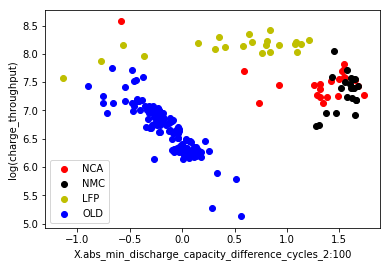

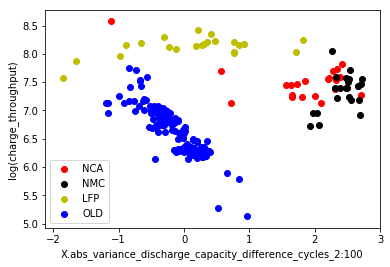

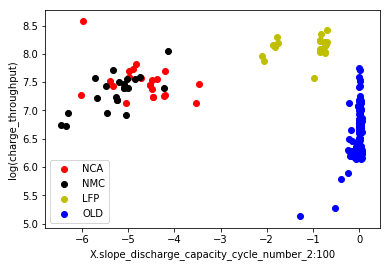

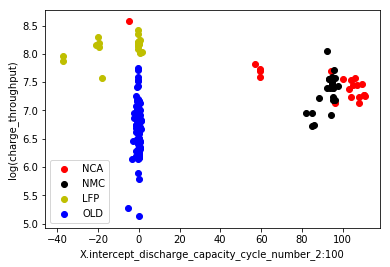

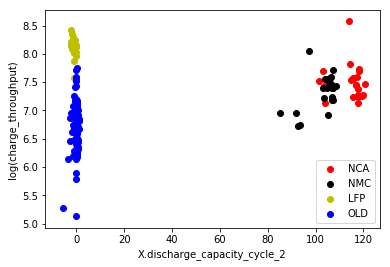

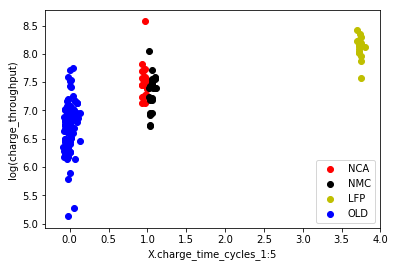

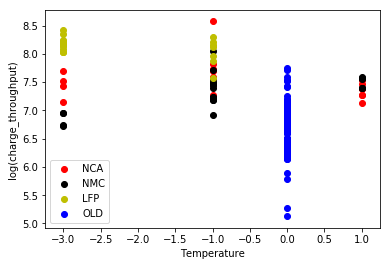

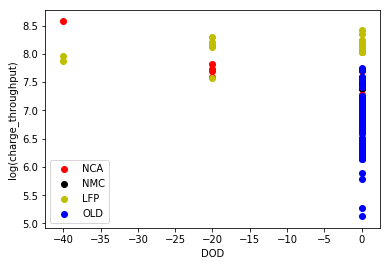

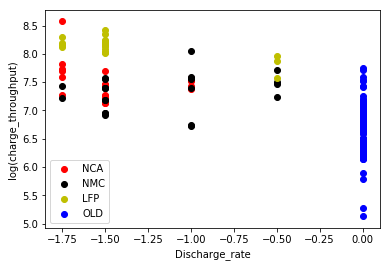

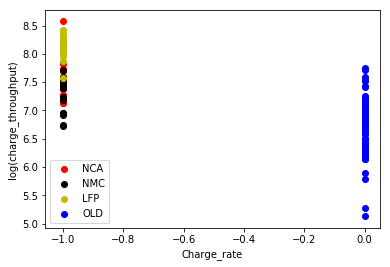

In [61]:
for feat in full_model_features:
    plt.scatter(full_df_sc[full_df_sc.chem == "NCA"][feat], 
                np.log(full_df_sc[full_df_sc.chem == "NCA"]["charge_throughput"]), color='r')
    plt.scatter(full_df_sc[full_df_sc.chem == "NMC"][feat], 
                np.log(full_df_sc[full_df_sc.chem == "NMC"]["charge_throughput"]), color='k')
    plt.scatter(full_df_sc[full_df_sc.chem == "LFP"][feat], 
                np.log(full_df_sc[full_df_sc.chem == "LFP"]["charge_throughput"]), color='y')
    plt.scatter(full_df_sc[full_df_sc.chem == "OLD"][feat], 
                np.log(full_df_sc[full_df_sc.chem == "OLD"]["charge_throughput"]), color='b')
    plt.xlabel(feat)
    labels = ["NCA", "NMC", "LFP", "OLD"]
    plt.ylabel("log(charge_throughput)")
    plt.legend(labels)
    plt.show()
    plt.close()